In [21]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras 
from keras.models import model_from_json
import skimage.transform

In [27]:
import numpy as np
import pydicom
import skimage.transform
import keras 
from keras.models import model_from_json
import matplotlib.pyplot as plt

def check_dicom(filename): 
    """
    Read DICOM file with additional validation checks.
    
    Args:
        filename (str): Path to the DICOM file
    
    Returns:
        numpy.ndarray or None: Image array if valid, else None
    """
    print(f'Load file {filename} ...')
    try:
        ds = pydicom.dcmread(filename)       
        img = ds.pixel_array
        
        # Validate modality
        modality = ds.Modality 
        if modality != 'DX':
            print('Modality is not DX. The image will not be assessed.')
            return None

        # Validate body part
        body_part = ds.BodyPartExamined
        if body_part != 'CHEST':
            print('Body part examined is not Chest. The image will not be assessed.')
            return None
        
        # Validate patient position
        patient_position = ds.PatientPosition 
        if patient_position not in ['PA', 'AP']:
            print('Patient position is not PA or AP. The image will not be assessed.')
            return None
        
        # Display findings and image
        findings = ds.get('StudyDescription', 'No findings description')
        print(f'Findings: {findings}')
        plt.imshow(img, cmap='gray')
        plt.title(f'DICOM Image: {findings}')
        plt.show()
        
        return img
    
    except Exception as e:
        print(f"Error processing DICOM file: {e}")
        return None

def preprocess_image(img, img_mean=0.5, img_std=0.5, img_size=(224, 224)): 
    """
    Preprocess image for model input.
    
    Args:
        img (numpy.ndarray): Input image
        img_mean (float): Mean for normalization
        img_std (float): Standard deviation for normalization
        img_size (tuple): Target image size
    
    Returns:
        numpy.ndarray: Preprocessed image
    """
    try:
        # Normalize and resize image
        proc_img = (img - img_mean) / img_std
        proc_img = skimage.transform.resize(proc_img, img_size)
        
        # Add channel dimension if needed
        if len(proc_img.shape) == 2:
            proc_img = np.expand_dims(proc_img, axis=-1)
        
        return proc_img
    
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None

def load_model(model_path, weight_path):
    """
    Load model from JSON and weights.
    
    Args:
        model_path (str): Path to model JSON
        weight_path (str): Path to model weights
    
    Returns:
        keras.Model: Loaded model
    """
    try:
        with open(model_path, 'r') as json_file:
            model_json = json_file.read()
            model = model_from_json(model_json)
            model.load_weights(weight_path)
        
        return model
    
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

def predict_image(model, img, thresh=0.5): 
    """
    Predict pneumonia presence.
    
    Args:
        model (keras.Model): Trained model
        img (numpy.ndarray): Preprocessed image
        thresh (float): Threshold for positive prediction
    
    Returns:
        str: Prediction result
    """
    try:
        # Ensure image has batch dimension
        if len(img.shape) == 3:
            img = np.expand_dims(img, axis=0)
        
        pred_Y = model.predict(img)[0][0]
        
        if pred_Y > thresh:
            return f'Pneumonia (Probability: {pred_Y:.2f})'
        else:
            return f'Not Pneumonia (Probability: {pred_Y:.2f})'
    
    except Exception as e:
        print(f"Error during prediction: {e}")
        return "Prediction failed"

Error loading model: Could not locate class 'Sequential'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'class_name': 'Sequential', 'config': {'name': 'sequential_1', 'layers': [{'class_name': 'Model', 'config': {'name': 'model_1', 'layers': [{'name': 'input_1', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_1'}, 'inbound_nodes': []}, {'name': 'block1_conv1', 'class_name': 'Conv2D', 'config': {'name': 'block1_conv1', 'trainable': False, 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bia

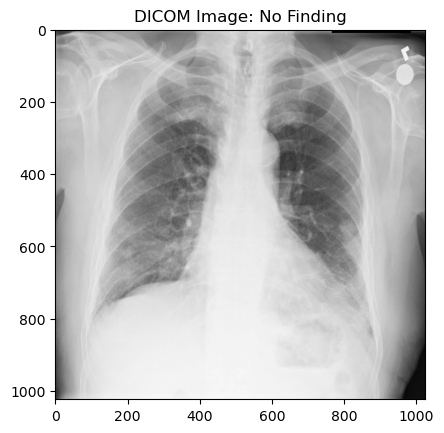

Error during prediction: 'NoneType' object has no attribute 'predict'
Prediction failed

Load file test2.dcm ...
Findings: Cardiomegaly


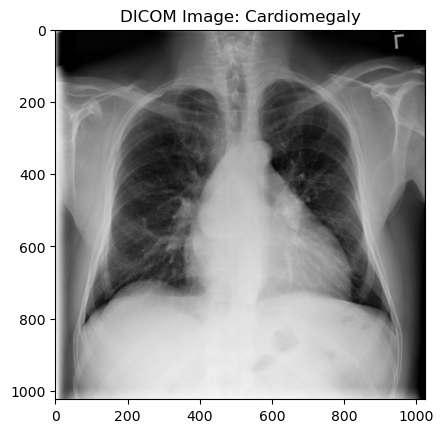

Error during prediction: 'NoneType' object has no attribute 'predict'
Prediction failed

Load file test3.dcm ...
Findings: Effusion


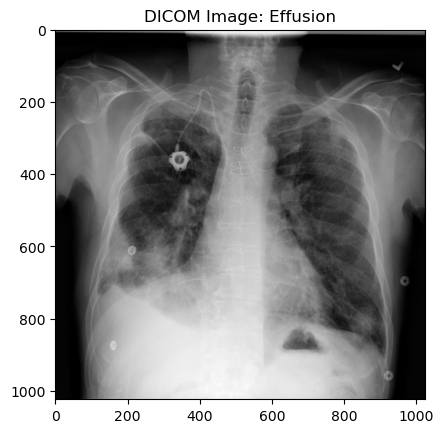

Error during prediction: 'NoneType' object has no attribute 'predict'
Prediction failed

Load file test4.dcm ...
Body part examined is not Chest. The image will not be assessed.
Load file test5.dcm ...
Modality is not DX. The image will not be assessed.
Load file test6.dcm ...
Patient position is not PA or AP. The image will not be assessed.


In [28]:
model_path = "/Users/mostafazaky/Project 1/model.json"
weight_path = "{}_model.best.hdf5".format('xray_class')

IMG_SIZE=(1,224,224,3) 
img_mean = 0
img_std = 255

my_model = load_model(model_path, weight_path)
thresh = 0.4035850763320923

# use the .dcm files to test your prediction
for i in test_dicoms:
    
    img = np.array([])
    img = check_dicom(i)
    
    if img is None:
        continue
        
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    print(pred)
    print()